In [1]:
!pip install pyLDAvis==3.2.1

     |████████████████████████████████| 1.7 MB 753 kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136161 sha256=4e0e207b58b9bafbfe4edb943c2b94e4c4db547bcf5c652a4cd856158b6ec270
  Stored in directory: /root/.cache/pip/wheels/c6/ee/a6/7c17a63623f940dff0b9cbd7e48a27543f088fa55a7d2b62d0
Successfully built pyLDAvis
  Attempting uninstall: pyLDAvis
    Found existing installation: pyLDAvis 3.3.1
    Uninstalling pyLDAvis-3.3.1:
      Successfully uninstalled pyLDAvis-3.3.1


In [2]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../input/prothom-alo-20192021/prothom_alo_2019_20.csv')
df.full_text = df.full_text.replace(np.nan, '')

In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df['full_text'].values.tolist()
data_words = list(sent_to_words(data))

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [6]:
col_name = 'full_text'

In [7]:
from textblob import TextBlob
df['polarity'] = df[col_name].apply(lambda x: TextBlob(x).polarity)

In [8]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
                           
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,2))
# matrix of ngrams
bgrams = c_vec.fit_transform(df['full_text'])
# count frequency of ngrams
count_values = bgrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_bgram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

_bgram = df_bgram.head(50)

import plotly.express as px
fig = px.bar(_bgram, x='bigram/trigram', y='frequency')
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Frequency of Bigrams", xaxis_title="Bigrams", yaxis_title="Frequency")
fig.show()

In [9]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
                           
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(3,3))
# matrix of ngrams
tgrams = c_vec.fit_transform(df['full_text'])
# count frequency of ngrams
count_values = tgrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_tgram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

_tgram = df_tgram.head(50)

import plotly.express as px
fig = px.bar(_tgram, x='bigram/trigram', y='frequency')
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Frequency of Trigrams", xaxis_title="Trigrams", yaxis_title="Frequency")
fig.show()

The sentiment function of textblob returns two properties, **polarity**, and **subjectivity**.

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(df['full_text'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

df_ngram['polarity'] = df_ngram['bigram/trigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram['subjective'] = df_ngram['bigram/trigram'].apply(lambda x: TextBlob(x).subjectivity)
pol = df_ngram.head(200)

In [11]:
import plotly.express as px
fig = px.bar(pol, x='bigram/trigram', y='polarity')
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Polarity of Bigrams & Trigrams", xaxis_title="Bigrams & Trigrams", yaxis_title="Sentiment Polarity")
fig.show()

In [12]:
import plotly.express as px
fig = px.bar(pol, x='bigram/trigram', y='subjective')
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Subjectivity of Bigrams & Trigrams", xaxis_title="Bigrams & Trigrams", yaxis_title="Sentiment Subjectivity")
fig.show()

## LDA

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [14]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [15]:
topic_model = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
topic_model.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', "Text"]
topic_model

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,2.0,0.6619,"say, injure, kill, police, truck, people, spot...","[college, student, kill, truck, hit, night, st..."
1,2.0,0.6822,"say, injure, kill, police, truck, people, spot...","[road, accident, claim, local, journalist, aft..."
2,2.0,0.8704,"say, injure, kill, police, truck, people, spot...","[least, people, kill, injure, road, accident, ..."
3,2.0,0.9499,"say, injure, kill, police, truck, people, spot...","[passenger, locally, know, mahendra, kill, inj..."
4,2.0,0.9785,"say, injure, kill, police, truck, people, spot...","[person, kill, road, accident, morning, report..."
...,...,...,...,...
225,2.0,0.9389,"say, injure, kill, police, truck, people, spot...","[people, kill, fall, report, identity, decease..."
226,2.0,0.8845,"say, injure, kill, police, truck, people, spot...","[least, people, injure, run, train, collided, ..."
227,2.0,0.5430,"say, injure, kill, police, truck, people, spot...","[least, worker, kill, injure, coal, laden, tru..."
228,2.0,0.9791,"say, injure, kill, police, truck, people, spot...","[least, people, kill, injure, truck, collide, ..."


In [16]:
# Format
df_dominant_topic = topic_model.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = topic_model.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.4844,"family, student, rush, member, village, physician, pronounce, treatment, teacher, flee","[life, cut, short, morning, hit, bicycle, ride, narail, teacher, station, say, front, bridge, pa..."
1,1.0,0.6526,"wheeler, movement, however, car, ply, operate, illegal, bribe, government, tree","[illegal, wheeler, ply, highway, increase, risk, accident, area, local, accuse, highway, police,..."
2,2.0,0.9806,"say, injure, kill, police, truck, people, spot, hit, bus, dead","[people, kill, injure, collision, vehicle, report, identity, deceased, could, collide, microbus,..."
3,3.0,0.6939,"accident, road, death, accord, year, labourer, level_crosse, number, time, dormitory","[road, accident, bangladesh, still, lead, cause, death, people, kill, accident, country, last, y..."


### Word Frequency Distribution

In [17]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

import plotly.figure_factory as ff
import numpy as np

# Add histogram data
x1 = doc_lens
# Group data together
hist_data = [x1]
group_labels = ['Word Count']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text="Distribution of Document Frequency", xaxis_title="Document Word Count", yaxis_title="Frequency")

fig.show()

### Topic Distribution

In [18]:
topics = lda_model.show_topics(formatted=False)

for i in range(len(topics)):
    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]

    # Add histogram data
    x1 = doc_lens
    # Group data together
    hist_data = [x1]
    group_labels = ['Word Count']
    # Create distplot with custom bin_size
    fig = ff.create_distplot(hist_data, group_labels)
    fig.update_layout(title_text="Distribution of Document Word Counts by Dominant Topic: Topic {}".format(i), xaxis_title="Document Word Count", yaxis_title="Number of Documents")

    fig.show()

In [19]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.336952  0.010066       1        1  72.457205
3      0.078025 -0.142386       2        1  10.698588
1      0.140482 -0.053146       3        1   9.403385
0      0.118446  0.185466       4        1   7.440822, topic_info=          Term        Freq       Total Category  logprob  loglift
0     accident  138.000000  138.000000  Default  30.0000  30.0000
32        road  117.000000  117.000000  Default  29.0000  29.0000
16         say  393.000000  393.000000  Default  28.0000  28.0000
9       injure  333.000000  333.000000  Default  27.0000  27.0000
10        kill  284.000000  284.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1098     stuck    4.409924    5.373877   Topic4  -5.0597   2.4005
1112  roadside    5.117629    6.480618   Topic4  -4.9109   2.3621
774      visit    4.962320    6.673289   Topic4  -4.9417   2.3019
742     mother    6.265160   10.838958   Topic4  -4.7085   2.0500
256       head    7.277251   22.575387   Topic4  -4.5588   1.4661

[181 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.607538  accident
0         2  0.368862  accident
0         3  0.028930  accident
149       2  0.964080    accord
1188      3  0.810862    action
...     ...       ...       ...
349       3  0.982247   wheeler
321       2  0.973601    worker
606       2  0.794489     would
273       4  0.893973     wound
209       2  0.966565      year

[179 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

### Word Cloud

Topic 0


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



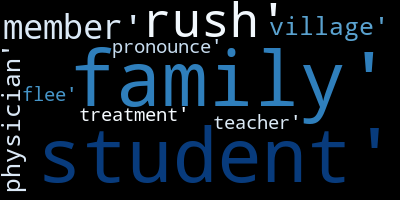

Topic 1


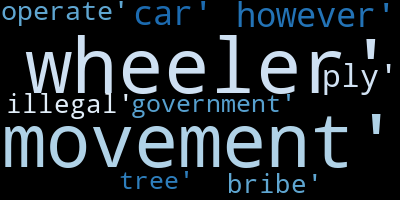

Topic 2


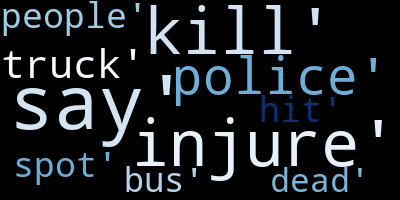

Topic 3


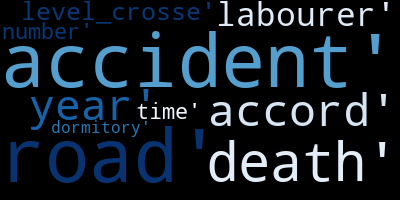

In [20]:
topics = lda_model.show_topics(formatted=False)

from PIL import Image
from wordcloud import WordCloud

def create_wordcloud(text):
    #stopwords = set(STOPWORDS)
    
    wc = WordCloud(background_color="black",
                  max_words=3000,
                  stopwords=stop_words,
                colormap='Blues',
                  repeat=False)
    wc.generate(str(text))
    wc.to_file("wc.png")
    
    path="wc.png"
    display(Image.open(path))
    
for i in range(len(topics)):
    print("Topic {}".format(i))
    topic_words = dict(topics[i][1])
    create_wordcloud(topic_words)

In [21]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Keywords from Topic Models

In [22]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])   

for i in range(len(topics)):
    data = df.loc[df.topic_id==i, :]
    data = data.sort_values('word_count', ascending = False)
    
    import plotly.express as px
    fig = px.bar(data, x='word', y='word_count')
    fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
    fig.update_layout(title_text="Topic Keywords: Topic {}".format(i), xaxis_title="Words", yaxis_title="Count")
    fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [23]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Documents by Dominant Topic

In [24]:
import plotly.express as px
fig = px.bar(df_dominant_topic_in_each_doc, x='Dominant_Topic', y='count')
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Document Count by Dominant Topic", xaxis_title="Topics", yaxis_title="Number of Documents")
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Documents by Topic Weightage

In [25]:
import plotly.express as px
fig = px.bar(df_topic_weightage_by_doc, x='index', y='count')
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Document Count by Topic Weightage", xaxis_title="Words", yaxis_title="Number of Documents")
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



* https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5

* https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/